In [ ]:
# Copyright 2020 MIT 6.S191 Introduction to Deep Learning. All Rights Reserved.
#
# Licensed under the MIT License. You may not use this file except in compliance
# with the License. Use and/or modification of this code outside of 6.S191 must
# reference:
#
# © MIT 6.S191: Introduction to Deep Learning
# http://introtodeeplearning.com
#
# Переклад -- Бояршин Ігор, ІВ-91мн

# Лабораторна 1: Навчання з підкріпленням

Навчання з підкріпленням (НП) є підмножиною машинного навчання, в якому завдання навчання постає у вигляді вдаємодії між агентами та навколишнім середовищем. Зазвичай передбачається, що агенти не мають попередніх знань про навколишній світ, і тому мають навчитися пересуватися по навколишньому середовищу шляхом оптимізації функції винагороди. У межах середовища агент може виконувати деякі дії та отримувати зворотній зв'язок у вигляді позитивної чи негативної винагороди в залежності від своїх дій. Таким чином, процес функціонування агента виглядає як метод "спроб та помилок", або як дитина навчалася б відрізняти "погане" від "хорошого".

Говорячи конкретно, наш НП агент буде взаємодіяти з середовищем, виконуючи дій у кожен момент часу, та отримуючи відповідну винагороду, за допомогої якої він буде змінювати свій стан і вчитися.

![alt text](https://www.kdnuggets.com/images/reinforcement-learning-fig1-700.jpg)

У той час як головною метою навчання з підкріпленням є навчання агента діяти у реальному фізичному середовищі, на практиці ігри є дуже зручним інструментом для розробки НП алгоритмів та агентів. Ігри мають набір характеристик, що робить їх дуже зручними для НП:

1.   В більшості випадків ігри мають чудово описане середовище. Наприклад, всі правила шахім можна легко описати та запрограмувати у симуляторі;
2.   Ігри легко піддаються розпаралелюванню. Оскільки їх не треба запускати у реальному світі, їх можна симулювати на великих кластерах даних;
3.   Прості сценарії в іграх дають можливість швидко накидати робочу модель. Це значно пришвидшує розробку алгоритмів, що в кінці кінців будуть запущені у реальному світі; а також...
4.   ... Ігри це весело!

У попередній роботі ми розглянули контрольоване (з LSTM, CNN) та неконтрольоване / напів-контрольоване (з VAE) завдання навчання. Навчання з підкріпленням фундаментально відрізняється, оскільки ми тренуємо глибинний алгоритм навчання керувати діями нашого агента, що намагається знайти оптимальний шлях досягнення мети у своєму середовищі. Метою тренування агента є визначення найкращого наступного кроку для отримання найбільшої кінцевої винагороди. У цій лабораторній роботі ми фокусуємось на створенні алгоритму навчання з підкріпленням для вивчення двох різних середовищ з різним рівнем складності.

1.   **Cartpole**:   Балансування стовпа, що стоїть на візку, у вертикальному положенні, пересуваючи візок тільки вліво та вправо. Малопросторове середовище спостереження.
2.   [**Pong**](https://en.wikipedia.org/wiki/Pong): Виграйте ваших опонентів (інший штучний інтелект або людей) у грі Pong. Великопросторове середовище спостереження -- навчання напряму з піксельних даних.

Почнемо! Спочатку заімпортуємо TensorFlow та декілька залежностей.


In [1]:
!apt-get install -y xvfb python-opengl x11-utils > /dev/null 2>&1
!pip install gym pyvirtualdisplay scikit-video > /dev/null 2>&1
!pip install gym[atari,accept-rom-license]
!pip install gym[classic_control]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 11.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.6.1-py3-none-any.whl size=446660 sha256=9c97255ee7a3672de12ffd5c406547c2b1d9c02834a666c966a8c1475166f9ff
  Stored in directory: /root/.cache/pip/wheels/6b/1b/ef/a43ff1a2f1736d5711faa1ba4c1f61be1131b8899e6a057811
Successfully built AutoROM.accept-rom-license
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 25.9 MB/s eta 0:00:00
  Attempting uninstall: pygame
    Found existing installation: pygame 2.5.2
    Uninstalling pygame-2.5.2:
      Successfully uninstalled pygame-2.5.2


In [2]:

%tensorflow_version 2.x
import tensorflow as tf

import numpy as np
import base64, io, time, gym
import IPython, functools
import matplotlib.pyplot as plt
from tqdm import tqdm

from IPython.display import HTML
import cv2


Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [3]:
# Допоміжні функції

def play_video(filename, width=None):
    encoded = base64.b64encode(io.open(filename, 'r+b').read())
    video_width = 'width="' + str(width) + '"' if width is not None else ''
    embedded = HTML(data='''
        <video controls {0}>
            <source src="data:video/mp4;base64,{1}" type="video/mp4" />
        </video>'''.format(video_width, encoded.decode('ascii')))

    return embedded


def preprocess_pong(image):
    I = image[35:195] # Crop
    I = I[::2, ::2, 0] # Downsample width and height by a factor of 2
    I[I == 144] = 0 # Remove background type 1
    I[I == 109] = 0 # Remove background type 2
    I[I != 0] = 1 # Set remaining elements (paddles, ball, etc.) to 1
    I = cv2.dilate(I, np.ones((3, 3), np.uint8), iterations=1)
    I = I[::2, ::2, np.newaxis]
    return I.astype(np.float)


def pong_change(prev, curr):
    prev = preprocess_pong(prev)
    curr = preprocess_pong(curr)
    I = prev - curr
    # I = (I - I.min()) / (I.max() - I.min() + 1e-10)
    return I


class Memory:
  def __init__(self):
      self.clear()

  # Resets/restarts the memory buffer
  def clear(self):
      self.observations = []
      self.actions = []
      self.rewards = []

  # Add observations, actions, rewards to memory
  def add_to_memory(self, new_observation, new_action, new_reward):
      self.observations.append(new_observation)
      self.actions.append(new_action)
      self.rewards.append(new_reward)


def aggregate_memories(memories):
  batch_memory = Memory()

  for memory in memories:
    for step in zip(memory.observations, memory.actions, memory.rewards):
      batch_memory.add_to_memory(*step)

  return batch_memory


def parallelized_collect_rollout(batch_size, envs, model, choose_action):

    assert len(envs) == batch_size, "Number of parallel environments must be equal to the batch size."

    memories = [Memory() for _ in range(batch_size)]
    next_observations = [single_env.reset() for single_env in envs]
    previous_frames = [obs for obs in next_observations]
    done = [False] * batch_size
    rewards = [0] * batch_size

    while True:

        current_frames = [obs for obs in next_observations]
        diff_frames = [pong_change(prev, curr) for (prev, curr) in zip(previous_frames, current_frames)]

        diff_frames_not_done = [diff_frames[b] for b in range(batch_size) if not done[b]]
        actions_not_done = choose_action(model, np.array(diff_frames_not_done), single=False)

        actions = [None] * batch_size
        ind_not_done = 0
        for b in range(batch_size):
            if not done[b]:
                actions[b] = actions_not_done[ind_not_done]
                ind_not_done += 1

        for b in range(batch_size):
            if done[b]:
                continue
            next_observations[b], rewards[b], done[b], info = envs[b].step(actions[b])
            previous_frames[b] = current_frames[b]
            memories[b].add_to_memory(diff_frames[b], actions[b], rewards[b])

        if all(done):
            break

    return memories


def save_video_of_model(model, env_name, suffix=""):
    import skvideo.io
    from pyvirtualdisplay import Display
    display = Display(visible=0, size=(400, 300))
    display.start()

    env = gym.make(env_name)
    obs = env.reset()
    prev_obs = obs

    filename = env_name + suffix + ".mp4"
    output_video = skvideo.io.FFmpegWriter(filename)

    counter = 0
    done = False
    while not done:
        frame = env.render(mode='rgb_array')
        output_video.writeFrame(frame)

        if "CartPole" in env_name:
            input_obs = obs
        elif "Pong" in env_name:
            input_obs = pong_change(prev_obs, obs)
        else:
            raise ValueError(f"Unknown env for saving: {env_name}")

        action = model(np.expand_dims(input_obs, 0)).numpy().argmax()

        prev_obs = obs
        obs, reward, done, info = env.step(action)
        counter += 1

    output_video.close()
    print("Successfully saved {} frames into {}!".format(counter, filename))
    return filename


def save_video_of_memory(memory, filename, size=(512,512)):
    import skvideo.io

    output_video = skvideo.io.FFmpegWriter(filename)

    for observation in memory.observations:
        output_video.writeFrame(cv2.resize(255*observation, size))

    output_video.close()
    return filename

In [16]:
import matplotlib.pyplot as plt

from IPython import display as ipythondisplay
from string import Formatter



def display_model(model):
  tf.keras.utils.plot_model(model,
             to_file='tmp.png',
             show_shapes=True)
  return ipythondisplay.Image('tmp.png')


def plot_sample(x,y,vae):
    plt.figure(figsize=(2,1))
    plt.subplot(1, 2, 1)

    idx = np.where(y==1)[0][0]
    plt.imshow(x[idx])
    plt.grid(False)

    plt.subplot(1, 2, 2)
    _, _, _, recon = vae(x)
    recon = np.clip(recon, 0, 1)
    plt.imshow(recon[idx])
    plt.grid(False)

    plt.show()



class LossHistory:
  def __init__(self, smoothing_factor=0.0):
    self.alpha = smoothing_factor
    self.loss = []
  def append(self, value):
    self.loss.append( self.alpha*self.loss[-1] + (1-self.alpha)*value if len(self.loss)>0 else value )
  def get(self):
    return self.loss

class PeriodicPlotter:
  def __init__(self, sec, xlabel='', ylabel='', scale=None):

    self.xlabel = xlabel
    self.ylabel = ylabel
    self.sec = sec
    self.scale = scale

    self.tic = time.time()

  def plot(self, data):
    if time.time() - self.tic > self.sec:
      plt.cla()

      if self.scale is None:
        plt.plot(data)
      elif self.scale == 'semilogx':
        plt.semilogx(data)
      elif self.scale == 'semilogy':
        plt.semilogy(data)
      elif self.scale == 'loglog':
        plt.loglog(data)
      else:
        raise ValueError("unrecognized parameter scale {}".format(self.scale))

      plt.xlabel(self.xlabel); plt.ylabel(self.ylabel)
      ipythondisplay.clear_output(wait=True)
      ipythondisplay.display(plt.gcf())

      self.tic = time.time()


def create_grid_of_images(xs, size=(5,5)):
    """ Combine a list of images into a single image grid by stacking them into an array of shape `size` """

    grid = []
    counter = 0
    for i in range(size[0]):
        row = []
        for j in range(size[1]):
          row.append(xs[counter])
          counter += 1
        row = np.hstack(row)
        grid.append(row)
    grid = np.vstack(grid)
    return grid

Перед тим як ми почнемо, давайте зробимо крок назад та визначемо наш підхід, що зазвичай використовується до будь-яких завдань навчання з підкріпленням:

1. **Ініціалізація середовища та агенту**: тут ми визначимо, що бачить агент, а також які дії він може виконувати у середовищі.
2. **Визначення пам'яті нашого агента**: це дозволить агенту запам'ятовувати свої попередні дії та винагороди.
3. **Визначення функції винагороди**: визначає винагороду за дію або послідовність дій.
4. **Визначення алгоритму навчання**: за допомогою цього буде виконано підкріплення хороших дій та покарання поганих дій агента.


# Частина 1: Cartpole

## 3.1 Визначення середовища Cartpole та агента

### Середовище

Для того щоб моделювати середовища для обох завдань, ми використаємо інструмент, зроблений за допомогою OpenAI, під назвою [OpenAI Gym](https://gym.openai.com/). Він пропонує декілька зазделегідь створених середовищ для тренування та тестування агентів навчання з підкріпленням, включаючи класичні завдання для фізичного контролю, відеоігри Atari, а також симуляції роботів. Для доступу до середовища Cartpole environment,ми використаємо `env = gym.make("CartPole-v0")`, до якого ми отримали доступ, підключивши пакет `gym`. Ми можемо створити різні [середовища](https://gym.openai.com/envs/#classic_control), передавши їх до функції `make`.

Однією з проблем, з якою ми можемо зтикнутися, створюючи НП алгоритми, це те, що багато аспектів навчання за своєю сутністю є випадковими: ініціалізація стану гри, зміна середовища, дії агента. Тому гарною ідеєю є встановлення початкового seed для середовища, аби забезпечити деякий рівень контролю. Так само як можна використовувати `numpy.random.seed`, ми викликаємо таку саму функцію у gym, `seed`, з нашим середовищем, для того аби наше середовище мало одні і ті самі випадкові величини при різних запусках.

In [6]:
 ### Ініціалізація середовища Cartpole ###

env = gym.make("CartPole-v1")
env.reset(seed=1)

array([ 0.00118216,  0.04504637, -0.03558404,  0.04486495], dtype=float32)

У Cartpole стовп прікріплений за допомогою шарніру до візка, що рухається вздовж шляху бех тертя. На початку стовп вертикальний, і метою є запобігання його падіння. Система контролюється шляхом прикладання сили зі значенням +1 чи -1 до візку. Винагорода +1 надається за кожен момент часу, коли стовп залишається вертикальним. Епізод закінчується коли стовп відхиляється більше ніж на 15 градусів від вертикалі, або візок від'їзжає більше ніж на 2.4 одиниці від центра шляху. Візуальна репрезентація візку зображена на малюнку нижче:

<img width="400px" src="https://danielpiedrahita.files.wordpress.com/2017/02/cart-pole.png"></img>

Маючи цей сетап середовища та цілей гри, ми можемо подумати про: 1) які спостереження можуть допомогти визначити стан середовища; 2) які дій ягент може робити.

Спочатку, подумаємо про спостереження. У цьому середовищі нашими спостереженнями будуть:

1. Позиція візку
2. Швидкість візку
3. Кут стовпа
4. Двишкість повороту стовпа

Ми можемо перевірити розмір простору, вивівши його на екран:


In [7]:
n_observations = env.observation_space
print("Environment has observation space =", n_observations)

Environment has observation space = Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


Далі, ми розглядаємо простір дій. На кожному кроці, агент може пересуватися або вліво або вправо. Ми знову ж таки можемо перевірити розмір простору, вивівши значення на екран:

In [8]:
n_actions = env.action_space.n
print("Number of possible actions that the agent can choose from =", n_actions)

Number of possible actions that the agent can choose from = 2


### Агент Cartpole

Тепер, коли ми задали середовище та зрозімули розмірність даних просторів спостереження та дій, ми готові визначати нашого агента. У глибинному навчанні з підкріпленням, агент задається глибинною нейронною мережею. Ця мережа буде брати на вхід спостережння середовища та видавати ймовірності виконання кожної з можливих дій. Оскільки Cartpole є простором з малою степенню, для агенту гарно підійде проста feed-forward нейронна мережа. Ми задамо це за допомогою `Sequential` API.


In [9]:
### Задаємо агента Cartpole ###

# Задаємо feed-forward нейронну мережу
def create_cartpole_model():
  model = tf.keras.models.Sequential([
      tf.keras.layers.Dense(units=32, activation='relu'),

      tf.keras.layers.Dense(units=n_actions, activation=None)
  ])
  return model

cartpole_model = create_cartpole_model()

Тепер, коли ми задали основну архітектуру мережі, ми визначимо *функцію дій*, що виконуватиме прямий прохід по мережі на основі множини спосережень, а також збирає вихід з мережі. На основі цього буде прийматися рішення про наступний крок агенту.

**Важливим моментом є те, що ця функція є загальною -- ми будемо використовувати її для Cartpole та Pong, але взагалі її можна використовувати і для інших завдань навчання з підкріпленням!**

In [10]:
### Визначимо фінкцію дій агента ###

# Функція, що бере на вхід множину спостережень, виконує прямий прохід по мережі,
#   і повертає обрану дію.
# Аргументи:
#   model: мережа, що визначає агента
#   observation: спостереження, що даються на вхід моделі
# Вихід:
#   action: вибрана дія агента
def choose_action(model, observation):
  observation = np.expand_dims(observation, axis=0)

  logits = model.predict(observation)
  prob_weights = tf.nn.softmax(logits).numpy()

  action = np.random.choice(n_actions, size=1, p=prob_weights.flatten())[0]

  return action

## 3.2 Визначаємо пам'ять агента

Тепер, коли ми визначили середовище та архітектуру мережі агента, а також функцію дій, ми готові перейти до наступного кроку у НП:
1. **Ініціалізація середовища та агента**: тут ми опишемо різні спостереження та дії, що їх може виконати агент у середовищі.
2. **Визначення пам'яті агента**: це дасть змогу агенту запам'ятовувати свої попередні дії та винагороди.
3. **Задання алгоритму навчання**: за допомогою цього буде виконано підкріплення хороших дій та покарання поганих дій агента.

У навчанні з підкріпленням, тренування виконується завдяки взаємодії агента з середовищем та виконання дій агентом; *епізодом* називається послідовність дій, що закінчується у якомусь кінцевому стані, як-от падіння стовпа чи аварія візку. Агенту потрібно буде пам'ятати усі його дії та спостереження, так що коли закінчується епізод, він зможе "підкріпити" хороші дії та "покарати" погані. Першим кроком є задання простого буферу пам'яті, що зберігає спостереження агента, його дії, а також отримані винагороди за конкретні епізоди.

**Знову ж таки, зверніть увагу на модульність цього буферу пам'яті -- він може та буде використовуватися у інших завданнях НП**

In [11]:
### Пам'яті агента ###

class Memory:
  def __init__(self):
      self.clear()

  # Стирає пам'ять
  def clear(self):
      self.observations = []
      self.actions = []
      self.rewards = []

  # Додаємо спостереження, дію та винагороду до пам'яті
  def add_to_memory(self, new_observation, new_action, new_reward):
      self.observations.append(new_observation)
      self.actions.append(new_action)
      self.rewards.append(new_reward)

memory = Memory()

## 3.3 Функція винагороди

Ми майже готові почати навчання нашого агенту! Наступним кроком є підрахунок винагород нашого агенту за його дії у середовищі. Оскільки ми (та агент) не знає напевно, коли закінчиться гра чи завдання (коли звалиться стовп), має сенс отримувати винагороду одразу, а не потім. Ця ідея схожа з отриманням грошей за проценти вкладу.

Для підрахунку очікуванної сумарної винагороди, яку ще називають **повернення**, у заданий момент часу у епізоді навчання, ми сумуємо винагороду зі знижкою на момент часу $t$, у межах епізоду навчання, з проектуванянм у майбутнє. Ми визначаємо повернення (сумарну винагороду) у час $t$, $R_{t}$, як:

>$R_{t}=\sum_{k=0}^\infty\gamma^kr_{t+k}$

де $0 < \gamma < 1$ це фактор знижки і $r_{t}$ це винагорода на кроці $t$, а індекс $k$ інкрементує проекцію у майбутнє у межах одного епізоду навчання. Інтуітивно можна думати, що ця функція занижує винагороди, що будуть отримані у майбутньому, і натомість примушує агента приорітизувати винагороди "зараз". Оскільки ми не можемо продовжити епізоди до нескінченності, на практиці підрахунок буде обмежений кількістю кроків у епізоді -- після цього вважаться, що винагорода рівна нулю.

Зверніть увагу на форму цієї суми -- нам потрібно буде подумати про те, як її реалізувати. Конкретніше, нам потрібно буде ініціалізувати масим нулями, з довжиною рівною кількості кроків, та заповнювати його реальними значеннями знижки винагороди по ходу того, як ми ітеруємося по винагородам епізоду, що зберігаються у пам'яті агента. Остаточно нам важливо, які дії краще у порівнянні з іншими діями у цьому епізоді -- тому ми нормалізуємо підраховані винагороди за допомогою середнього та стандартного відхилення винагород по всім епізодам.


In [12]:
### Функція винагород ###

# Допоміжна функція, що нормалізує масив
def normalize(x):
  x -= np.mean(x)
  x /= np.std(x)
  return x.astype(np.float32)

# Підраховує нормалізовані, скидочні, а також сумарні винагороди (тобто, повернення)
# Аргументи:
#   rewards: винагорода у кожний момент часу
#   gamma: ступінь скидки
# Повертає:
#   Нормалізовану скидочну винагороду
def discount_rewards(rewards, gamma=0.95):
  discounted_rewards = np.zeros_like(rewards)
  R = 0
  for t in reversed(range(0, len(rewards))):
      R = R * gamma + rewards[t]
      discounted_rewards[t] = R

  return normalize(discounted_rewards)

## 3.4 Алгоритм навчання

Тепер ми можемо почати визначати алгоритм навчання, що буде використовуватися для підкріплення хороших дій агента та карати за погані дії. У цій роботі ми зфокусуємося на методах *стратегій градієнту*, метою яких є **максимізація** вірогідності дій, що призводять до великої винагороди. Аналогічно, це означає що потрібно **мінімізувати** негативну вірогідність цих же дій. Ми досягаємо цього множенням вірогідностей на їх відповідну винагороду -- таким чином підсилюючи силу дій з великою винагородою.

Оскільки функція логаримфу монотонно зростає, це означає що мінімізація **негативної вірогідності** еквівалентна мінімізації **негативного логарифму вірогідності**. Згадаймо, що ми можемо легко підрахувати негативний логарифм вірогідності дискретних дій, обчисливши його  [softmax cross entropy](https://www.tensorflow.org/api_docs/python/tf/nn/sparse_softmax_cross_entropy_with_logits). Як і у навчанні з учителем, можна використати стокастичний градієнтий спуск для отримання бажаної мінімізації.

Почнемо з визначення функції втрат.

In [13]:
### Функція втрат ###

# Аргументи:
#   logits: прогнози мережи щодо дій
#   actions: дії, що виконам агент в епізоді
#   rewards: винагороди, що отримав агент у епізоді
# Повертає:
#   втрату
def compute_loss(logits, actions, rewards):
  neg_logprob = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=actions)

  loss = tf.reduce_mean( neg_logprob * rewards )
  return loss

Тепер використаємо функцію втрат для визначення кроку тренування алгоритму:

In [14]:
### Крок тренування (forward та backpropagation) ###

def train_step(model, optimizer, observations, actions, discounted_rewards):
  with tf.GradientTape() as tape:
      logits = model(observations)
      loss = compute_loss(logits, actions, discounted_rewards)

  grads = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(grads, model.trainable_variables))


## 3.5 Запускаємо!

Оскільки у агента немає попередніх знань про середовище, він почне навчатися балансувати стовп на візку, базуючись лише на зворотньому зв'язку, отриманому з середовища! Визначивши можливі дії нашого агента, як він отримує нові спостереження, а також як він оновлює свій стан, ми побачимо як він поступово навчається стратегії дій для оптимізації балансування стовпа так довго, як тільки можна. Для цього ми будемо спостерігати, як змінюються винагороди в залежності від тренування -- як вони мають змінюватися по ходу тренування?

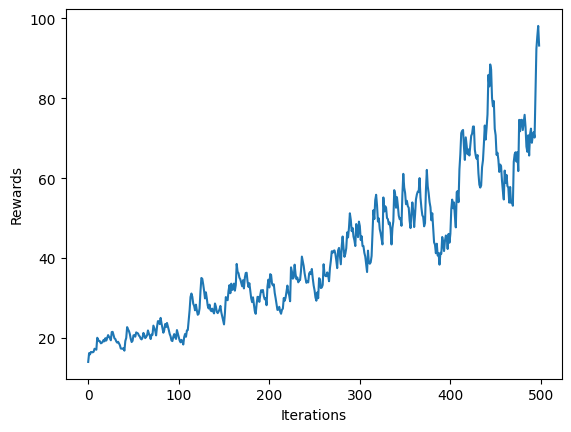

1/1 [==============================] - 0s 20ms/step


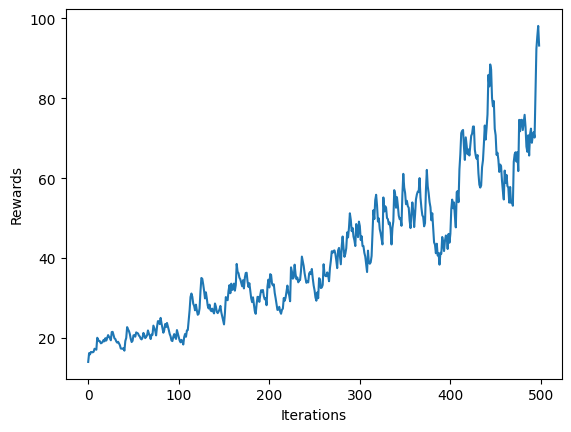

In [17]:
### Тренування Cartpole! ###

# Швидкість навчання та оптимізатор
learning_rate = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate)

# створення агенту
cartpole_model = create_cartpole_model()

# для слідкування за прогресом
smoothed_reward = LossHistory(smoothing_factor=0.9)
plotter = PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Rewards')

if hasattr(tqdm, '_instances'): tqdm._instances.clear() # очистити якщо існує
for i_episode in range(500):

  plotter.plot(smoothed_reward.get())

  # Перезапустити середовище
  observation = env.reset()
  memory.clear()

  while True:
      # на основі спостережень, вибрати дію та зробити її в середовищі
      action = choose_action(cartpole_model, observation)
      next_observation, reward, done, info = env.step(action)
      # додати до пам'яті
      memory.add_to_memory(observation, action, reward)

      # епізод закінчився? сталася аварія, чи все так добре, що ми закінчили?
      if done:
          # Визначити сумарну винагороду та додати її
          total_reward = sum(memory.rewards)
          smoothed_reward.append(total_reward)

          # почати тренування -- ми нічого не знаємо про те, як впорається агент до того, як він потрапить у аварію
          train_step(cartpole_model, optimizer,
                     observations=np.vstack(memory.observations),
                     actions=np.array(memory.actions),
                     discounted_rewards = discount_rewards(memory.rewards))

          # очистити пам'ять
          memory.clear()
          break
      # оновити спостереження
      observation = next_observation

Для того щоб дізнатися як впорався агент, ми можемо зробити відео натренованої моделі в процесі балансування. Майте на увазі, що це повністю незнайоме для нього середовище!

Давайте подивимося створене відео і побачимо, як впорався наш агент!


In [20]:
!sudo apt-get install xvfb

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings
  xfonts-utils xserver-common
The following NEW packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings
  xfonts-utils xserver-common xvfb
0 upgraded, 9 newly installed, 0 to remove and 18 not upgraded.
Need to get 7,812 kB of archives.
After this operation, 11.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfontenc1 amd64 1:1.1.4-1build3 [14.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxfont2 amd64 1:2.0.5-1build1 [94.5 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxkbfile1 amd64 1:1.1.0-1build3 [71.8 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/main amd64 x11-xkb-utils amd64 7.7+5build4 [172 kB]
Get:5 http://archiv

In [21]:
saved_cartpole = save_video_of_model(cartpole_model, "CartPole-v1")
play_video(saved_cartpole)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/skvideo/io/abstract.py:514: DeprecationWarning: tostring() is deprecated. Use toby

Successfully saved 459 frames into CartPole-v1.mp4!


Як все пройшло? Чи можливо зменшити час тренування та все ще показати гарний результат? Чи збільшення часу тренування дасть кращий результат?

## Частина 2: Pong

У Cartpole ми працювали зі статичним середовищем -- іншими словами, воно не змінювалося із часом. Але що відбудеться, якщо наше середовище буде динамчним та непередбачуваним? Саме це відбувається у [Pong](https://en.wikipedia.org/wiki/Pong), оскільки частиною середовища є наш опонент. Ми не знаємо, як опонент будет реагувати на наші дії, а тому збільшується складність задачі. Задача також стає значно цікавішою, адже ми можемо навчитися перемагати нашого опонента. НП дає нам потужний інструмент для тренування систем штучного інтелекту з можливістю взаємодії з динамічним та непередбачуваним середовищем. У цій частині роботи ми використаємо ті самі інструменти, що і у першій частині, для побудови НП агенту, здатного грату в гру Pong.


## 3.6 Визначення та вивчення середовища Pong

Як і з Cartpole, ми створемо середовище Pong у OpenAI gym з seed рівним 1.

In [23]:
env = gym.make("Pong-v4", frameskip=5)
env.seed(1) # для відтворюваності

(1835504127, 1731038949)

Тепер давайте подумаємо про простір спостереження середовища Pong. Замість фізичного опису моделі з чотирьох складових, як ми зробили у Cartpole, у Pong нашими спостереженнями будуть окремі кадри відео, на яких зображено стан ігрового поля. Таким чином, спостерженнями є окремі RGB картинки з роздільною здатністю 210x160 RGB та розмірністю (210,160,3).

Зному ж таки, ми можемо перевірити це, вивівши простір спостереження на екран:

In [24]:
print("Environment has observation space =", env.observation_space)

Environment has observation space = Box(0, 255, (210, 160, 3), uint8)


У грі Pong на кожному кроці агент (що контролює дощечку) має на вибір 6 дій: не робити нічного, рухатися направо, наліво, стріляти, стріляти направо, стріляти наліво. Давайте підтвердимо розмір простору дій:

In [25]:
n_actions = env.action_space.n
print("Number of possible actions that the agent can choose from =", n_actions)

Number of possible actions that the agent can choose from = 6


## 3.7 Визначення агенту Pong

Як і раніше, ми використаємо нейронну мережу для задання нашого агента. Яка, на вашу думку, архітектура мережі найкраще підійде для цієї гри? Оскільки нашими спостереженнями є картинки, ми додамо згорткові шари до мережі для підвищення якості навчання.

In [26]:
### Визначення агента Pong ###

# Функціонально задаємо шари для зручності
# Усі згорткові шари матимуть активаційну функцію ReLu
Conv2D = functools.partial(tf.keras.layers.Conv2D, padding='same', activation='relu')
Flatten = tf.keras.layers.Flatten
Dense = tf.keras.layers.Dense

# Задамо CNN для агенту Pong
def create_pong_model():
  model = tf.keras.models.Sequential([
    # Згорткові шари
    # Спочатку, 16 7x7 фільтрів та 4x4 stride
    Conv2D(filters=16, kernel_size=7, strides=4),

    Conv2D(filters=32, kernel_size=5, strides=2),

    Conv2D(filters=48, kernel_size=3, strides=2),

    Flatten(),

    # Повнозв'язний шар та вихід
    Dense(units=64, activation='relu'),
    # Зверніть увагу на розмірність простору дій агента
    Dense(units=n_actions, activation=None)

  ])
  return model

pong_model = create_pong_model()

Оскільки ми уже визначали функцію дій, `choose_action(model, observation)`, ще раз це робити нам не потрібно. Замість цього, ми зможемо використати її ще раз пізніше, передавши її до нової моделі, `pong_model`. Це чудово, оскільки наша функція дій є модульною та загальною для будь-яких НП агентів!

## 3.8 Сцецифічні для Pong функції

У першій частині (Cartpole), ми зробили декілька спеціальних функцій для побудови та тренування нашого НП агента -- `choose_action(model, observation)` та клас `Memory`, наприклад. Однак для того аби використати їх у нашій грі Pong, нам потрібно зробити декілька невеликих модифікацій.

Наприклад, потрібно визначити, що буде, коли гра закінчиться. У Pong, ми знаємо що гра закінчилась якщо вінагорода складає +1 (ми перемогли!) або -1 (ми програли). В інших випадках, ми очікуємо нульову винагороду на кожному кроці -- гравці змагаються один з одним. Тому, коли гра закінчиться, нам потрібно буде зкинути винагороду до 0. Тому функція винагороди зміниться.

In [27]:
### Функція винагороди Pong ###

# Обчислимо нормалізовані та знижкові винагороди для Pong (тобто повернення)
# Аргументи:
#   rewards: винагорода на кожному кроці епізоду
#   gamma: множник знижки. Ми підвищили його до 0.99 -- менший ступінь зменшення із часом.
# Повертає:
#   нормалізовану знижкову винагороду
def discount_rewards(rewards, gamma=0.99):
  discounted_rewards = np.zeros_like(rewards)
  R = 0
  for t in reversed(range(0, len(rewards))):
      # Нове: онуляємо суму, якщо винагорода не рівна нулю (гра закінчилась)
      if rewards[t] != 0:
        R = 0
      # оновлюємо загальну знижкову винагороду, як і раніше
      R = R * gamma + rewards[t]
      discounted_rewards[t] = R

  return normalize(discounted_rewards)

Також нам потрібно подумати про природу спостережень у середовищі Pong, і як вона буде передаватися до нашої мережі. Перед тим як передавати картинку у наши мережу, ми зробимо невеличку обробку зображення, а саме обріжемо та розтягнемо його, почистимо задній план до єдиного кольору, а також переведемо важливі компоненти гри в один колір. Давайте візуалізуємо, як буде виглядати кадр до та після обробки.

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
<ipython-input-3-5eac7ab425fd>:20: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return I.astype(np.float)


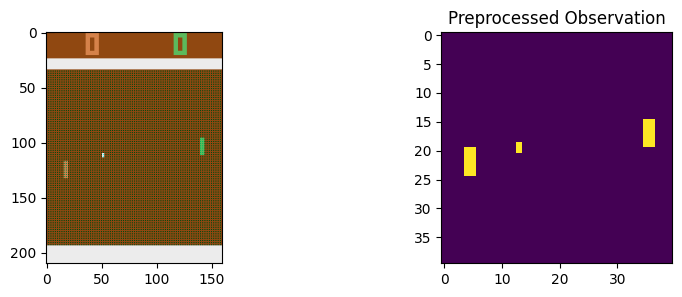

In [28]:
observation = env.reset()
for i in range(30):
  observation, _,_,_ = env.step(0)
observation_pp = preprocess_pong(observation)

f = plt.figure(figsize=(10,3))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax.imshow(observation); ax.grid(False);
ax2.imshow(np.squeeze(observation_pp)); ax2.grid(False); plt.title('Preprocessed Observation');

Що ви помітили? Як можуть ці зміни бути важливими для тренування нашого НП алгоритму?

## 3.9 Тренування Pong

Тепер ми готові до початку тренування нашого НП алгоритму та агенту для гри у Pong!
Ми вже визначили нашу функцію втрат -- `compute_loss`, яка використовує стратегію вивчення градієнту, а також нашу функцію кроку backpropagation з `train_step`! Ми будемо використовувати ці функції для тренування агенту Pong agent. Давайте пройдемося по блокам тренування.

У грі Pong, замість того щоб передавати нашій мережі одну картинку в один момент часу, натомість краще буде передавати різницю між двома сусідніми спостереженнями, що дає нам інформацію про зміщення між кадрами -- як змінюється гра. Спочатку ми обробимо початкові спостерження, `x`, а потім підрахуємо різницю від попереднього зображення.

Ця зміна спостереження пройде крізь нашого агента Pong, модель мережі CNN, що потім прийме рішення щодо наступної дії, базуючись на цьому спостереженні. Буде порахована звичайна винагорода, після чого спостереження, дія та винагорода будуть збережені до пам'яті. Це буде продовжуватися доки не закінчиться епізод тренування, тобто сама гра.

Далі ми підрахуємо знижкову винагороду, і використаємо цю інформацію для виконання кроку тренування. Пам'ять буде стерта, і ми зробимо все спочатку!

Давайте запустимо блок коду для тренування нашого агента Pong. Зверніть увагу, що сам процес тренування на цей раз займе значно більше часу (декілька годин). Потім ми зному зробимо візуалізацію остаточних винагород як функцію від тренування, для того щоб побачити як тренується агент.

In [2]:
### Тренування Pong ###

# Гіперпараметри
learning_rate=1e-4
MAX_ITERS = 4 # Збільште максимальну кількість епізодів до 1000

# Модель та оптимізатор
pong_model = create_pong_model()
optimizer = tf.keras.optimizers.Adam(learning_rate)

# побудова графіків
smoothed_reward = LossHistory(smoothing_factor=0.9)
plotter = PeriodicPlotter(sec=5, xlabel='Iterations', ylabel='Rewards')
memory = Memory()

for i_episode in range(MAX_ITERS):

  plotter.plot(smoothed_reward.get())

  # Перезапускаємо середовище
  observation = env.reset()
  previous_frame = preprocess_pong(observation)

  while True:
      # Обробляємо картинку
      current_frame = preprocess_pong(observation)

      obs_change = current_frame - previous_frame

      action = choose_action(pong_model, obs_change)
      # Зробимо вибрану дію
      next_observation, reward, done, info = env.step(action)

      memory.add_to_memory(obs_change, action, reward)

      # епізод закінчився?
      if done:
          # визначимо загальну винагороду та запам'ятаємо її
          total_reward = sum(memory.rewards)
          smoothed_reward.append( total_reward )

          # починаємо тренування
          train_step(pong_model,
                     optimizer,
                     observations = np.stack(memory.observations, 0),
                     actions = np.array(memory.actions),
                     discounted_rewards = discount_rewards(memory.rewards))

          memory.clear()
          break

      observation = next_observation
      previous_frame = current_frame

NameError: ignored

Нарешті, тепер ми можемо перевірити, як натренувався наш агент. Він зіграє у ново-створеному середовищі Pong проти комп'ютера, базової системи штучного інтелекту для Pong. Наш агент грає за зелену дощечку. Давайте подивимось на матч!

In [1]:
saved_pong = save_video_of_model(
    pong_model, "Pong-v4", obs_diff=True,
    pp_fn=preprocess_pong)
play_video(saved_pong)

NameError: ignored

## 3.10 Висновки

На цьому все! Вітаємо з тренуванням двох агентів та перевіркою їх роботи! Пропонуємо дати відповідь на такі питання:

*   Як показав себе агент на практиці для кожного середовища?

*   Чи можна витратити менше часу на тренування та все ще показати гарний результат?

*   Чи вважаєте ви, що збільшуючи час навчання агентта ми могли б покращити результат ще більше?

* Як складність між Pong та Cartpole впливає на швидкість тренування та загальний результат?

* Які речі можна змінити у агенті або процесі навчання для того аби покращити результат?